```
python {CIRCRIP_PATH}/circRIP.py EnrichedcircRNA \
            -ip_circ {input.ip_circ} \
            -input_circ {input.in_circ} \
            -gtf {input.gtf} \
            -ip_bam {input.ip_bam} \
            -input_bam {input.in_bam} \
            -prefix {output} \
            -G {input.genome}
```

[zero inflation](https://easystats.github.io/performance/reference/check_zeroinflation.html)
[chi square test for zero inflation](https://stats.stackexchange.com/questions/118322/how-to-test-for-zero-inflation-in-a-dataset)

[cgam and stepwise AIC](https://online.stat.psu.edu/stat504/lesson/8/8.2/8.2.2)
[heteroscedasticity](https://timeseriesreasoning.com/contents/introduction-to-heteroscedasticity/)
[Poisson regression](http://dwoll.de/rexrepos/posts/regressionPoisson.html)
[zero inflation poisson](https://stats.oarc.ucla.edu/r/dae/zip/)

cat /home/hsher/scratch/circ_nextera*/output/*.bed | sort -k1,1 -k2,2n -k3,3n | uniq > ~/scratch/all_circles.bed
bedtools nuc -s -fi /home/hsher/gencode_coords/GRCh38.primary_assembly.genome.fa -bed ~/scratch/all_circles.bed > ~/scratch/circles_gc_content.nuc

In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plot_params import *
from pathlib import Path
import numpy as np

# beta-binom coef

In [2]:
coef = pd.read_csv('/home/hsher/scratch/rar11_input.coef.tsv', sep = '\t')
counts = pd.read_csv('/home/hsher/scratch/rar11_input.tsv', sep = '\t')

In [ ]:
coef['rho'].median()

In [4]:
from scipy.special import expit

In [5]:

rho = expit(coef['rho'])[0] # the inverse of logit.
rho

0.00010154881997080002

In [6]:
rho_constant = expit(-1.1465074)

In [7]:
rho_rm_zero = expit(-3.094e+00)

In [8]:
rho_constant 

0.24112759878566764

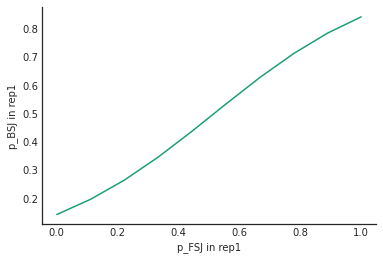

In [9]:
mu_intercept = -1.793e+00 
mu_beta = 3.473e+00
p_fsj = np.linspace(0,1,10)
mu_vs_fsj = expit(mu_intercept+mu_beta*p_fsj)
plt.plot(p_fsj, mu_vs_fsj)
plt.xlabel('p_FSJ in rep1')
plt.ylabel('p_BSJ in rep1')
sns.despine()

Text(0, 0.5, 'rho')

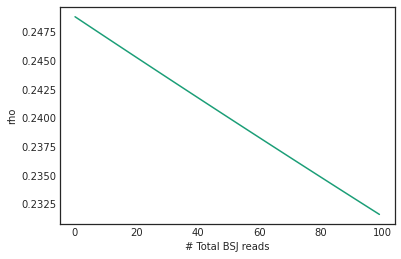

In [10]:
rho_changes_intercept = -1.104917e+00
rho_changes_beta = -9.538e-04
total_reads = np.arange(0,100)
logit_rho = rho_changes_intercept+rho_changes_beta*total_reads
rho_w_nread = expit(logit_rho)
plt.plot(total_reads, rho_w_nread)
plt.xlabel('# Total BSJ reads')
plt.ylabel('rho')

In [11]:
def get_alpha_beta(mu, rho):
    #https://dcgerard.github.io/updog/reference/betabinom.html
    
    alpha = mu*(1-rho)/rho
    beta=(1-mu)*(1-rho)/rho
    
    return alpha, beta
    

# Plot the variablility between 2 reps

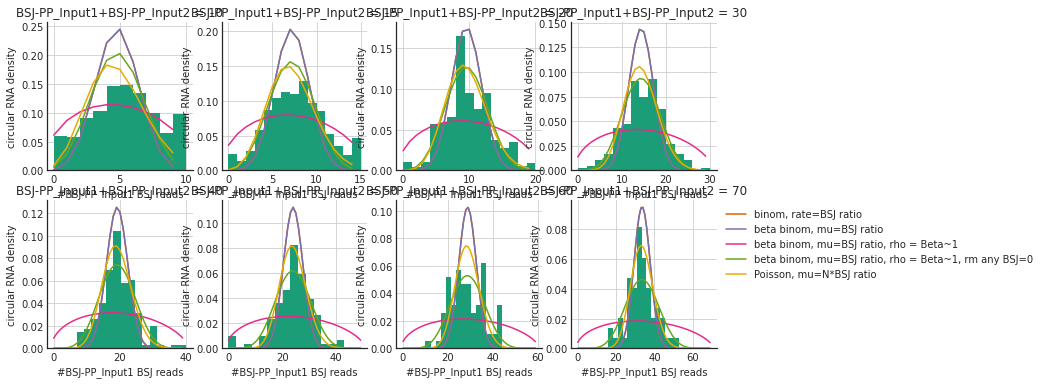

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from scipy.stats import betabinom
from scipy.stats import poisson
rep1='PP_Input1'
rep2='PP_Input2'
r1_handle = f'BSJ-{rep1}'
r2_handle = f'BSJ-{rep2}'

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
counts['total_bsj']=counts[r1_handle]+counts[r2_handle]
total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
bsj_rate = total_bsj[r1_handle]/total_bsj.sum()

f, axes = plt.subplots(2,4, figsize = (12,6))
for cov, ax in zip([10,15,20,30,40,50,60,70,120], axes.flatten()):
    
    counts.loc[counts[[r1_handle, r2_handle]].sum(axis = 1)==cov, r1_handle].hist(
        ax = ax, density = True, bins = min(cov, 15))
    ax.set_title(f'{r1_handle}+{r2_handle} = {cov}')
    ax.set_xlabel(f'#{r1_handle} BSJ reads')
    ax.set_ylabel('circular RNA density')
    
    ax.plot(binom(cov, bsj_rate).pmf(np.arange(cov)), label = 'binom, rate=BSJ ratio')
    
    alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho) # rather arbitrary, betabinom did not figure out how to find coeff for rho despite zero=NULL
    bb_bsj=betabinom(cov, a=alpha_bsj, b = beta_bsj)
    ax.plot(bb_bsj.pmf(np.arange(cov)), label = 'beta binom, mu=BSJ ratio')
    
    alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho_constant) # rather arbitrary, betabinom did not figure out how to find coeff for rho despite zero=NULL
    bb_bsj=betabinom(cov, a=alpha_bsj, b = beta_bsj)
    ax.plot(bb_bsj.pmf(np.arange(cov)), label = 'beta binom, mu=BSJ ratio, rho = Beta~1')
    
    alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho_rm_zero) # rather arbitrary, betabinom did not figure out how to find coeff for rho despite zero=NULL
    bb_bsj=betabinom(cov, a=alpha_bsj, b = beta_bsj)
    ax.plot(bb_bsj.pmf(np.arange(cov)), label = 'beta binom, mu=BSJ ratio, rho = Beta~1, rm any BSJ=0')
    
    poi_bsj= poisson(cov*bsj_rate)
    ax.plot(poi_bsj.pmf(np.arange(cov)), label = 'Poisson, mu=N*BSJ ratio')
    
sns.despine()
ax.legend(bbox_to_anchor = (1,1))

# Judge model fit by QQ plot

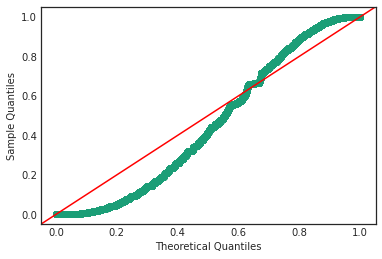

In [13]:
IN='PP_Input1'
IP='PP_Input2'

r1_handle = f'BSJ-{IP}'
r2_handle = f'BSJ-{IN}'

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
bsj_rate = total_bsj[r1_handle]/total_bsj.sum()
alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho)

counts['total_bsj']=counts[r1_handle]+counts[r2_handle]

counts[f'pvalue_null']=counts.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                                            a=alpha_bsj, b = beta_bsj).cdf(row[r1_handle]), axis =1)

FDR_threshold = 20
from statsmodels.stats.multitest import fdrcorrection
rejected, counts[f'FDR_null'] = fdrcorrection(counts[f'pvalue_null'],
                          alpha = FDR_threshold)
import statsmodels.api as sm
import scipy
p = sm.qqplot(counts.loc[counts['total_bsj']>10,f'pvalue_null'], line ='45',
             dist=scipy.stats.uniform)

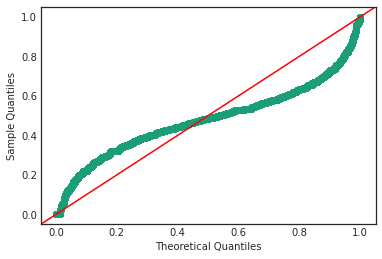

In [14]:
IN='PP_Input1'
IP='PP_Input2'

r1_handle = f'BSJ-{IP}'
r2_handle = f'BSJ-{IN}'

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
bsj_rate = total_bsj[r1_handle]/total_bsj.sum()
alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho_constant)

counts['total_bsj']=counts[r1_handle]+counts[r2_handle]

counts[f'pvalue_null_const']=counts.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                                            a=alpha_bsj, b = beta_bsj).cdf(row[r1_handle]), axis =1)

FDR_threshold = 20
from statsmodels.stats.multitest import fdrcorrection
rejected, counts[f'FDR_null'] = fdrcorrection(counts[f'pvalue_null_const'],
                          alpha = FDR_threshold)
import statsmodels.api as sm
import scipy
p = sm.qqplot(counts.loc[counts['total_bsj']>10,f'pvalue_null_const'], line ='45',
             dist=scipy.stats.uniform)

In [15]:
unique_count_combinations = counts[['total_bsj', r1_andle]].drop_duplicates()
unique_count_combinations[f'pvalue_{IP}']=unique_counht_combinations.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                        a=alpha_bsj, 
                                        b = beta_bsj)                                                                      
    


In [16]:
counts.shape

(125726, 29)

In [17]:
merged = counts.merge(unique_count_combinations, left_on = ['total_bsj', r1_handle],
             right_on = ['total_bsj', r1_handle])

In [18]:
merged[['pvalue_PP_Monosome1_y', 'pvalue_PP_Monosome1_x']]

KeyError: "None of [Index(['pvalue_PP_Monosome1_y', 'pvalue_PP_Monosome1_x'], dtype='object')] are in the [columns]"

In [ ]:
IN='PP_Input1'
IP='PP_Input2'

r1_handle = f'BSJ-{IP}'
r2_handle = f'BSJ-{IN}'

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
bsj_rate = total_bsj[r1_handle]/total_bsj.sum()
alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho_rm_zero)

counts['total_bsj']=counts[r1_handle]+counts[r2_handle]

counts[f'pvalue_null_const']=counts.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                                            a=alpha_bsj, b = beta_bsj).cdf(row[r1_handle]), axis =1)

FDR_threshold = 20
from statsmodels.stats.multitest import fdrcorrection
rejected, counts[f'FDR_null'] = fdrcorrection(counts[f'pvalue_null_const'],
                          alpha = FDR_threshold)
import statsmodels.api as sm
import scipy
p = sm.qqplot(counts.loc[counts['total_bsj']>10,f'pvalue_null_const'], line ='45',
             dist=scipy.stats.uniform)

In [ ]:
sub = counts.loc[(counts[r1_handle]>0)&(counts[r2_handle]>0)]
sub['p_fsj']=sub['FSJ-PP_Input1']/(sub['FSJ-PP_Input1']+sub['FSJ-PP_Input2'])
sub['p_bsj']=sub['BSJ-PP_Input1']/(sub['BSJ-PP_Input1']+sub['BSJ-PP_Input2'])
sns.kdeplot(data = sub, x = 'p_fsj', y = 'p_bsj')

In [ ]:
IN='PP_Input2'
IP='PP_Monosome2'


r1_handle = f'BSJ-{IP}'
r2_handle = f'BSJ-{IN}'

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
bsj_rate = total_bsj[r1_handle]/total_bsj.sum()
alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho_rm_zero)


counts['total_bsj']=counts[r1_handle]+counts[r2_handle]
counts[f'pvalue_{IP}']=counts.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                                            a=alpha_bsj, b = beta_bsj).cdf(row[r1_handle]), axis =1)

FDR_threshold = 0.2
from statsmodels.stats.multitest import fdrcorrection

counts['perc_read']=(counts[r1_handle]/counts[r1_handle].sum())+(counts[r2_handle]/counts[r2_handle].sum())

counts['perc_read_bins']=pd.qcut(counts['perc_read'], q = 100, duplicates = 'drop', labels = False)
n_rejected = []
for nread_bin in counts['perc_read_bins'].value_counts().sort_index(ascending = False).index:
    rejected, fdr = fdrcorrection(counts.loc[counts['perc_read_bins']>nread_bin, f'pvalue_{IP}'],
                                  alpha = FDR_threshold)
    n_rejected.append([nread_bin, rejected.sum()])
n_rejected = pd.DataFrame(n_rejected, columns = ['perc_read_bin', 'n_rejected'])
n_rejected.set_index('perc_read_bin')['n_rejected'].plot()
threshold = n_rejected.set_index('perc_read_bin')['n_rejected'].idxmax()

results = counts.loc[counts['perc_read_bins']>threshold]
results['rejected'], results[f'FDR_{IP}'] = fdrcorrection(results[f'pvalue_{IP}'],
                          alpha = FDR_threshold)
results.loc[results['gene_name']=='ZNF609', [f'FDR_{IP}', 'circ_id']]

counts[f'FDR_{IP}']=results[f'FDR_{IP}']
counts[f'tested_{IP}']=counts.index.isin(results.index)

In [ ]:
counts

In [ ]:
IN='PP_Input1'
IP='PP_Monosome1'

r1_handle = f'BSJ-{IP}'
r2_handle = f'BSJ-{IN}'

total_bsj = counts[[r1_handle, r2_handle]].sum(axis = 0)
bsj_rate = total_bsj[r1_handle]/total_bsj.sum()
alpha_bsj, beta_bsj = get_alpha_beta(bsj_rate, rho_rm_zero)


counts['total_bsj']=counts[r1_handle]+counts[r2_handle]
counts[f'pvalue_{IP}']=counts.apply(lambda row: 1-betabinom(row['total_bsj'], 
                                                            a=alpha_bsj, b = beta_bsj).cdf(row[r1_handle]), axis =1)

FDR_threshold = 0.2
from statsmodels.stats.multitest import fdrcorrection
rejected, counts[f'FDR_{IP}'] = fdrcorrection(counts[f'pvalue_{IP}'],
                          alpha = FDR_threshold)

counts[f'fc_{IP}']=(counts[f'BSJ-{IP}']/counts['total_bsj'])/(bsj_rate)
counts['perc_read']=(counts[r1_handle]/counts[r1_handle].sum())+(counts[r2_handle]/counts[r2_handle].sum())

counts['perc_read_bins']=pd.qcut(counts['perc_read'], q = 100, duplicates = 'drop', labels = False)
n_rejected = []
for nread_bin in counts['perc_read_bins'].value_counts().sort_index(ascending = False).index:
    rejected, fdr = fdrcorrection(counts.loc[counts['perc_read_bins']>nread_bin, f'pvalue_{IP}'],
                                  alpha = FDR_threshold)
    n_rejected.append([nread_bin, rejected.sum()])
n_rejected = pd.DataFrame(n_rejected, columns = ['perc_read_bin', 'n_rejected'])
n_rejected.set_index('perc_read_bin')['n_rejected'].plot()
threshold = n_rejected.set_index('perc_read_bin')['n_rejected'].idxmax()

results = counts.loc[counts['perc_read_bins']>threshold]
results['rejected'], results[f'FDR_{IP}'] = fdrcorrection(results[f'pvalue_{IP}'],
                          alpha = FDR_threshold)
results.loc[results['gene_name']=='ZNF609', [f'FDR_{IP}', 'circ_id']]
counts[f'FDR_{IP}']=results[f'FDR_{IP}']
counts[f'tested_{IP}']=counts.index.isin(results.index)

In [ ]:
p = sm.qqplot(counts.loc[counts['total_bsj']>10,f'pvalue_{IP}'], line ='45',
             dist=scipy.stats.uniform)

In [ ]:
from matplotlib_venn import venn2
import statsmodels.api as sm
venn2([set(counts.loc[counts[f'FDR_PP_Monosome2']<FDR_threshold, 'circ_id']), 
       set(counts.loc[counts[f'FDR_PP_Monosome1']<FDR_threshold, 'circ_id'])
      ]
       )

In [ ]:
counts[f'pvalue_PP_Monosome1'].hist()

In [ ]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat
def read_circRIP_outputs(indir, sample1, sample2):
    rip_output = pd.read_csv(Path(indir)/'circRIP/'/f'{sample1}_vs_{sample2}',
    sep = '\t', names = ['circ_id', 'gene', 'BSJs in IP',
            'circRNA in Input','CPM in IP','CPM in Input',
            'IP/Input ratio','p-value', 'status'],
                comment = '>'
            )
    # annotation
    circ_df, stat = read_ciri_gtf(Path(indir)/f'{sample1}.gtf')
    rip_output = rip_output.merge(circ_df, left_on = 'circ_id', right_on = 'circ_id')
    return rip_output

In [ ]:
monosome_output1_1 = read_circRIP_outputs('/home/hsher/scratch/circ_nextera_iter8/output/', 'PP_Monosome1', 'PP_Input1')
monosome_output1_2 = read_circRIP_outputs('/home/hsher/scratch/circ_nextera_iter8/output/', 'PP_Monosome2', 'PP_Input2')

In [ ]:
venn2([set(monosome_output1_1.loc[monosome_output1_1['status']=='enriched', 'circ_id']),
       set(monosome_output1_2.loc[monosome_output1_2['status']=='enriched', 'circ_id'])]
     )

In [ ]:
f=sm.qqplot(monosome_output1_1.loc[(monosome_output1_1['circRNA in Input']+monosome_output1_1['BSJs in IP'])>10, 'p-value'], line ='45',
             dist=scipy.stats.uniform)


In [ ]:
monosome_output1_1['p-value'].hist()

In [ ]:
counts

In [ ]:
# comare the results

transcirc = pd.read_csv('transcirc_metadata.tsv', sep = '\t')
transcirc['circ_id']=transcirc['chrom']+':'+transcirc['start'].astype(str)+'|'+transcirc['end'].astype(str)
transcirc.drop_duplicates(subset = ['circ_id'], inplace = True)

In [ ]:
counts['both_enriched']=(counts[f'FDR_PP_Monosome2']<FDR_threshold)&(counts[f'FDR_PP_Monosome1']<FDR_threshold)

In [ ]:
counts['circRIP']=(counts['circ_id'].isin(monosome_output1_1.loc[monosome_output1_1['status']=='enriched', 'circ_id'])
)&(counts['circ_id'].isin(monosome_output1_2.loc[monosome_output1_2['status']=='enriched', 'circ_id']))

In [ ]:
venn2([set(counts.loc[counts['both_enriched'], 'circ_id']),
       set(counts.loc[counts['circRIP'], 'circ_id'])]
     )

In [ ]:
all_data = counts.merge(transcirc, left_on = 'circ_id', right_on = 'circ_id')

In [ ]:
all_data.loc[all_data['gene_name']=='ZNF609', ['circ_id','both_enriched', 'circRIP', 
                                              'FDR_PP_Monosome2', f'FDR_PP_Monosome1',
                                               
                                              ]]

In [ ]:
all_data.boxplot(by = ['both_enriched', 'circRIP'], column = 'evidences_num')

In [ ]:
all_data.boxplot(by = ['both_enriched', 'circRIP'], column = 'evidences_score')

In [ ]:
all_data.boxplot(by = ['both_enriched', 'circRIP'], column = 'm6A')

In [ ]:
all_data.boxplot(by = ['both_enriched', 'circRIP'], column = 'IRES')

In [ ]:
all_data.groupby(by = ['both_enriched', 'circRIP'])['MS'].value_counts()

In [ ]:
all_data.groupby(by = ['both_enriched', 'circRIP'])['ORF'].value_counts()